In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from timeit import default_timer as timer

In [2]:
# Вспомогательная функция для доступа к файлам относительно корня директория с данными.
INPUT_ROOT = "../input/gtsrb-german-traffic-sign"
def from_input(path):
    return os.path.join(INPUT_ROOT, path)

In [3]:
# Загружаем таблицу с данными о данных.
train_info = pd.read_csv(from_input("Train.csv"))
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
# Посмотрим как выглядят наши данные.
train_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [5]:
# сколько примеров в каждом из классов
train_info.groupby('ClassId')['ClassId'].count()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: ClassId, dtype: int64

In [6]:
test_info =  pd.read_csv(from_input("Test.csv"))
test_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
test_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000,12630.000000
mean,50.507759,50.364450,5.998021,5.982423,44.864450,44.758116,15.551069
std,25.088483,23.698908,1.543954,1.427424,23.776102,22.494697,11.947123
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,29.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,57.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000


In [8]:
# сколько примеров в каждом из классов
test_info.groupby('ClassId')['ClassId'].count()

ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: ClassId, dtype: int64

In [9]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Показываем изображения в сетке 6х8.
nrows = 8
ncols = 6

pic_offset = 0 # Чтобы итерировать по изображениям каждый раз когда запустим код ниже.

In [10]:
def show_images(offset):
    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)

    for i in range(43):
        # subplot индексы начинаются с 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        subdir = os.path.join(from_input('train'), str(i))
        files = os.listdir(subdir)
        img_path = os.path.join(subdir, files[offset % len(files)])
        img = mpimg.imread(img_path)
        #print(img.shape)
        plt.imshow(img)

    plt.show()

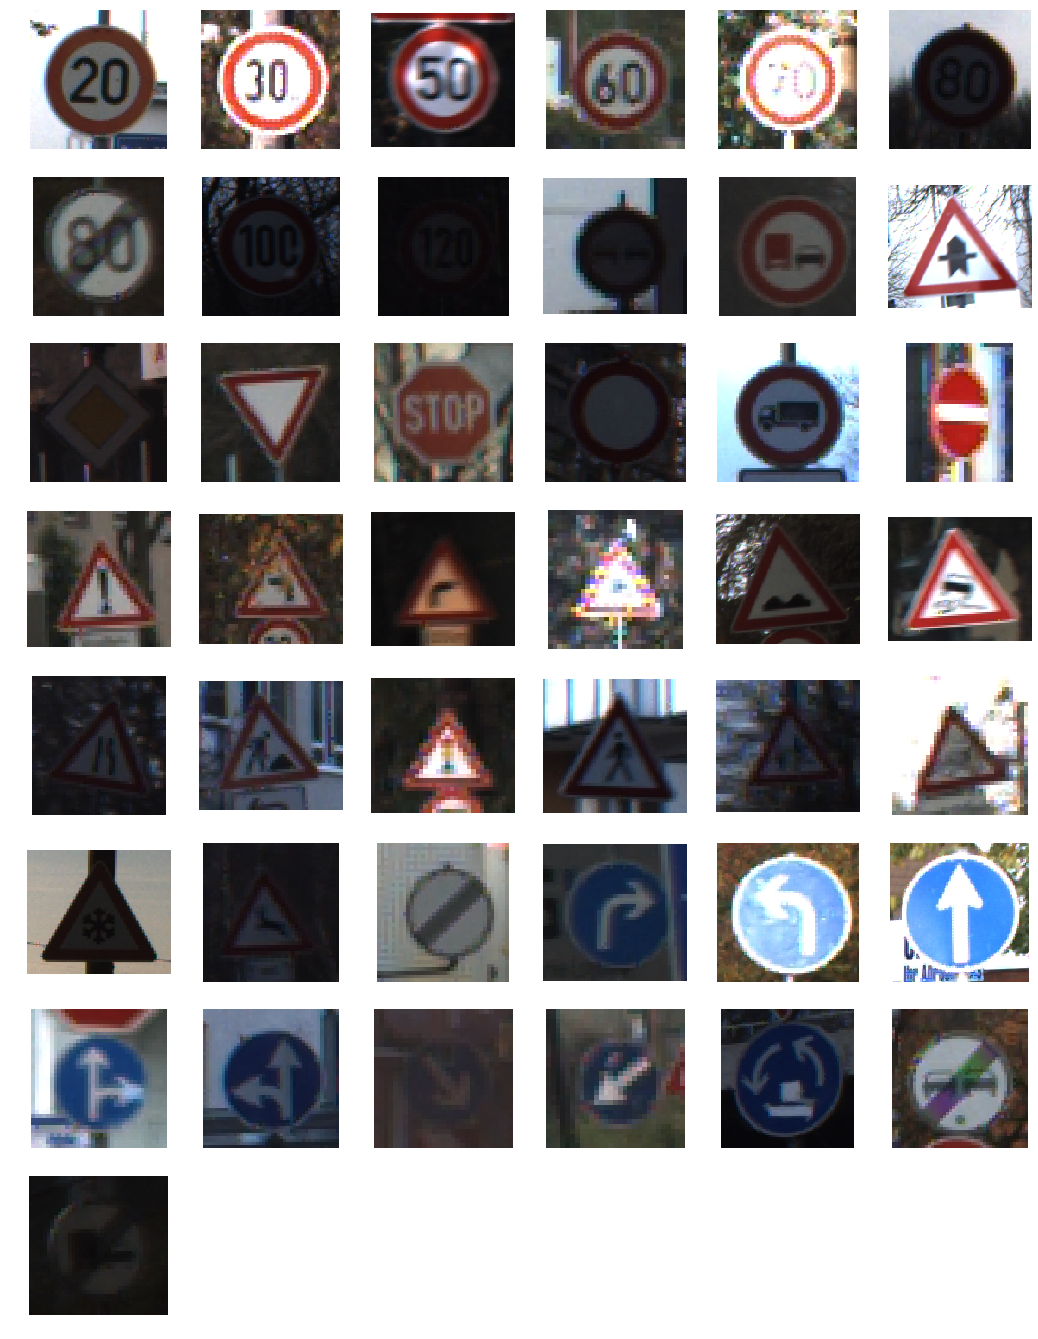

In [11]:
show_images(pic_offset)
pic_offset += 1

Загрузка и подготовка данных:

In [12]:
TARGET_SIZE = (40, 40) # изображения будут изменены до этого размера

In [13]:
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]

data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = Image.open(os.path.join(from_input('train'), f.replace('Train/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

X_train = np.array(data).astype('float32') / 255.0
y_train = to_categorical(y_train, 43)

print('Data loaded.              ')

Data loaded.              


In [14]:
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = Image.open(os.path.join(from_input('test'), f.replace('Test/', '')))
    resized_image = image.resize(TARGET_SIZE)
    data.append(np.array(resized_image))

X_test = np.array(data).astype('float32') / 255.0

print('Data loaded.              ')

Data loaded.              


Некоторые вспомогательные функции:

In [15]:
def plot(history):
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    acc=history.history['acc']
    loss=history.history['loss']
    epochs=range(len(acc))

    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.title('Training accuracy')
    plt.xlabel('Epoch')
    plt.figure()

    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.xlabel('Epoch')
    plt.title('Training loss')

In [16]:
def show_layers(model):
    print('Name\tOutput shape\t\tActivation\tInitializer')
    for l in model.layers:
        print('{0}({1})\t{2}\t{3}\t{4}'
            .format(l.name,
              l.__class__.__name__,
              l.output_shape,
              l.activation.__name__ if hasattr(l, 'activation') else '<none>',
              l.kernel_initializer.__class__.__name__ if hasattr(l, 'kernel_initializer') else '<none>'))


def custom_summary(model):
    model.summary()
    show_layers(model)

In [17]:
VERBOSE=1

In [18]:
def train_model(model, kernel_initializer, optimizer, epochs):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    BATCH_SIZE = 300
    start_time = timer()
    history = model.fit(X_train,
                        y_train,
                        batch_size = BATCH_SIZE,
                        epochs=epochs,
                        shuffle=False,
                        verbose=VERBOSE,
                        steps_per_epoch= round(X_train.shape[0] / BATCH_SIZE))
    end_time = timer()
    
    custom_summary(model)
    print('==============================')
    print('Initializer: ', kernel_initializer)
    print('Optimizer: ', optimizer.__class__.__name__)
    print('Learning rate: ', optimizer.get_config()['learning_rate'])
    print('Epochs: ', epochs)
    print('==============================')
    print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))

    acc=history.history['acc'][-1]
    test_acc = model.evaluate(X_test, y_test)[1]
    
    print('Results at the end of training: acc={1:.02f}%, test_acc={2:.02f}%'
          .format(i, acc*100, test_acc*100))
    
    plot(history)

Тренируем сети:

Epoch 1/30
131/131 [==============================] - 21s 163ms/step - loss: 3.1866 - acc: 0.2418
Epoch 2/30
131/131 [==============================] - 21s 157ms/step - loss: 2.1139 - acc: 0.4792
Epoch 3/30
131/131 [==============================] - 21s 157ms/step - loss: 1.5945 - acc: 0.6054
Epoch 4/30
131/131 [==============================] - 20s 156ms/step - loss: 1.2725 - acc: 0.6892
Epoch 5/30
131/131 [==============================] - 20s 156ms/step - loss: 1.0618 - acc: 0.7415
Epoch 6/30
131/131 [==============================] - 20s 156ms/step - loss: 0.9113 - acc: 0.7791
Epoch 7/30
131/131 [==============================] - 20s 156ms/step - loss: 0.8001 - acc: 0.8055
Epoch 8/30
131/131 [==============================] - 21s 161ms/step - loss: 0.7122 - acc: 0.8261
Epoch 9/30
131/131 [==============================] - 21s 159ms/step - loss: 0.6440 - acc: 0.8422
Epoch 10/30
131/131 [==============================] - 21s 159ms/step - loss: 0.5863 - acc: 0.8560
Epoch 11/30
131/131

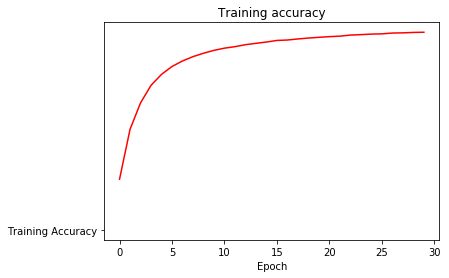

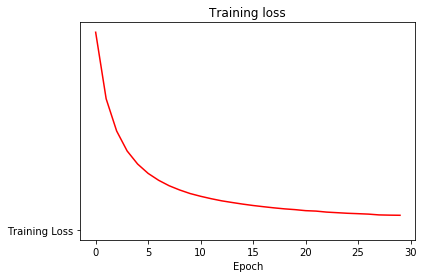

In [19]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.001)
epochs=30

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=TARGET_SIZE + (3,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Попробуем добавлять слои:

Epoch 1/30
131/131 [==============================] - 21s 160ms/step - loss: 3.1183 - acc: 0.2353
Epoch 2/30
131/131 [==============================] - 21s 160ms/step - loss: 1.9647 - acc: 0.4725
Epoch 3/30
131/131 [==============================] - 21s 160ms/step - loss: 1.4663 - acc: 0.6023
Epoch 4/30
131/131 [==============================] - 21s 160ms/step - loss: 1.1690 - acc: 0.6786
Epoch 5/30
131/131 [==============================] - 21s 159ms/step - loss: 0.9800 - acc: 0.7303
Epoch 6/30
131/131 [==============================] - 21s 159ms/step - loss: 0.8515 - acc: 0.7656
Epoch 7/30
131/131 [==============================] - 21s 162ms/step - loss: 0.7470 - acc: 0.7931
Epoch 8/30
131/131 [==============================] - 21s 158ms/step - loss: 0.6715 - acc: 0.8142
Epoch 9/30
131/131 [==============================] - 21s 158ms/step - loss: 0.6118 - acc: 0.8295
Epoch 10/30
131/131 [==============================] - 21s 158ms/step - loss: 0.5624 - acc: 0.8453
Epoch 11/30
131/131

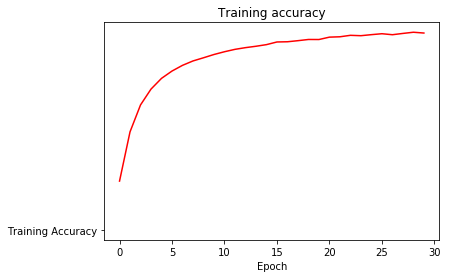

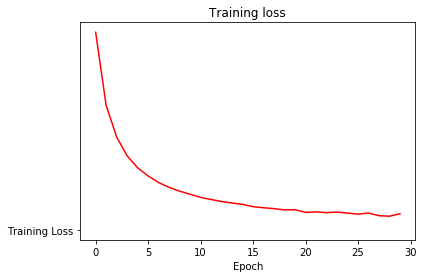

In [20]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.001)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Добавление больше слоёв кажется бессмысленным. Но попробуем изменить количество нейронов.

Epoch 1/30
131/131 [==============================] - 23s 175ms/step - loss: 2.9695 - acc: 0.2603
Epoch 2/30
131/131 [==============================] - 23s 174ms/step - loss: 1.9164 - acc: 0.5114
Epoch 3/30
131/131 [==============================] - 23s 174ms/step - loss: 1.4151 - acc: 0.6357
Epoch 4/30
131/131 [==============================] - 23s 174ms/step - loss: 1.1177 - acc: 0.7103
Epoch 5/30
131/131 [==============================] - 23s 177ms/step - loss: 0.9255 - acc: 0.7593
Epoch 6/30
131/131 [==============================] - 23s 174ms/step - loss: 0.7822 - acc: 0.7967
Epoch 7/30
131/131 [==============================] - 23s 174ms/step - loss: 0.6807 - acc: 0.8228
Epoch 8/30
131/131 [==============================] - 23s 174ms/step - loss: 0.6036 - acc: 0.8428
Epoch 9/30
131/131 [==============================] - 23s 174ms/step - loss: 0.5363 - acc: 0.8588
Epoch 10/30
131/131 [==============================] - 23s 174ms/step - loss: 0.4863 - acc: 0.8717
Epoch 11/30
131/131

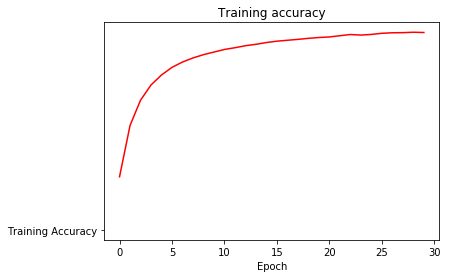

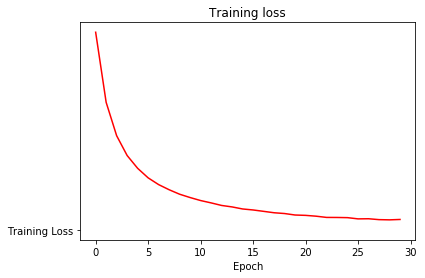

In [21]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0005)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/30
131/131 [==============================] - 23s 176ms/step - loss: 3.0767 - acc: 0.2167
Epoch 2/30
131/131 [==============================] - 23s 179ms/step - loss: 2.1554 - acc: 0.4347
Epoch 3/30
131/131 [==============================] - 23s 175ms/step - loss: 1.6513 - acc: 0.5541
Epoch 4/30
131/131 [==============================] - 23s 175ms/step - loss: 1.3309 - acc: 0.6368
Epoch 5/30
131/131 [==============================] - 23s 175ms/step - loss: 1.1074 - acc: 0.6956
Epoch 6/30
131/131 [==============================] - 23s 175ms/step - loss: 0.9489 - acc: 0.7377
Epoch 7/30
131/131 [==============================] - 23s 175ms/step - loss: 0.8284 - acc: 0.7698
Epoch 8/30
131/131 [==============================] - 23s 177ms/step - loss: 0.7341 - acc: 0.7969
Epoch 9/30
131/131 [==============================] - 23s 177ms/step - loss: 0.6538 - acc: 0.8190
Epoch 10/30
131/131 [==============================] - 23s 176ms/step - loss: 0.5902 - acc: 0.8364
Epoch 11/30
131/131

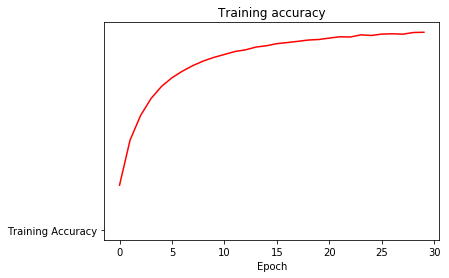

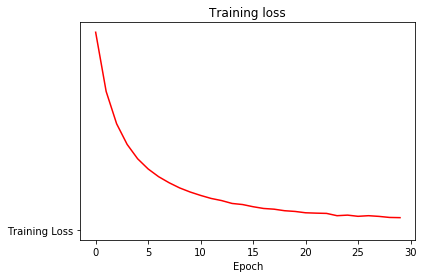

In [22]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0005)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(64, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/30
131/131 [==============================] - 26s 198ms/step - loss: 2.9764 - acc: 0.2735
Epoch 2/30
131/131 [==============================] - 26s 197ms/step - loss: 1.8381 - acc: 0.5255
Epoch 3/30
131/131 [==============================] - 26s 197ms/step - loss: 1.3215 - acc: 0.6527
Epoch 4/30
131/131 [==============================] - 26s 197ms/step - loss: 1.0234 - acc: 0.7300
Epoch 5/30
131/131 [==============================] - 26s 197ms/step - loss: 0.8378 - acc: 0.7782
Epoch 6/30
131/131 [==============================] - 26s 197ms/step - loss: 0.6978 - acc: 0.8162
Epoch 7/30
131/131 [==============================] - 26s 197ms/step - loss: 0.6075 - acc: 0.8366
Epoch 8/30
131/131 [==============================] - 26s 197ms/step - loss: 0.5303 - acc: 0.8592
Epoch 9/30
131/131 [==============================] - 26s 198ms/step - loss: 0.4675 - acc: 0.8729
Epoch 10/30
131/131 [==============================] - 26s 200ms/step - loss: 0.4168 - acc: 0.8900
Epoch 11/30
131/131

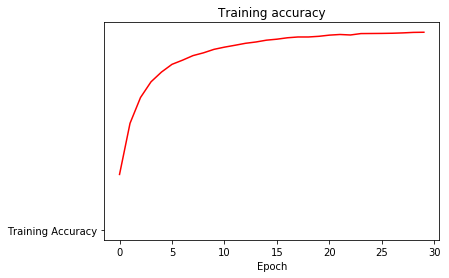

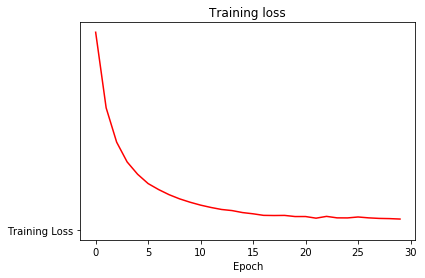

In [23]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0005)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(512, activation='relu', kernel_initializer=kernel_initializer),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/30
131/131 [==============================] - 25s 195ms/step - loss: 2.9781 - acc: 0.3155
Epoch 2/30
131/131 [==============================] - 25s 194ms/step - loss: 1.7607 - acc: 0.5812
Epoch 3/30
131/131 [==============================] - 26s 196ms/step - loss: 1.2558 - acc: 0.7017
Epoch 4/30
131/131 [==============================] - 25s 194ms/step - loss: 0.9750 - acc: 0.7683
Epoch 5/30
131/131 [==============================] - 25s 193ms/step - loss: 0.7988 - acc: 0.8065
Epoch 6/30
131/131 [==============================] - 25s 194ms/step - loss: 0.6753 - acc: 0.8364
Epoch 7/30
131/131 [==============================] - 25s 194ms/step - loss: 0.5846 - acc: 0.8574
Epoch 8/30
131/131 [==============================] - 25s 193ms/step - loss: 0.5154 - acc: 0.8741
Epoch 9/30
131/131 [==============================] - 25s 193ms/step - loss: 0.4602 - acc: 0.8864
Epoch 10/30
131/131 [==============================] - 25s 194ms/step - loss: 0.4145 - acc: 0.8985
Epoch 11/30
131/131

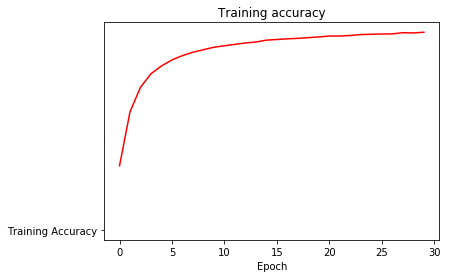

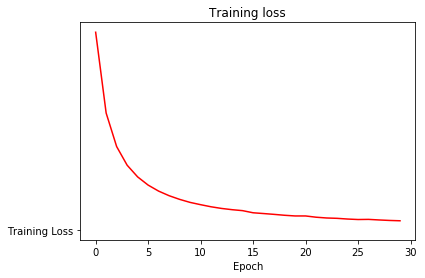

In [24]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0005)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(512, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/30
131/131 [==============================] - 23s 174ms/step - loss: 2.9504 - acc: 0.2960
Epoch 2/30
131/131 [==============================] - 23s 174ms/step - loss: 1.8506 - acc: 0.5639
Epoch 3/30
131/131 [==============================] - 23s 173ms/step - loss: 1.3533 - acc: 0.6860
Epoch 4/30
131/131 [==============================] - 23s 173ms/step - loss: 1.0652 - acc: 0.7522
Epoch 5/30
131/131 [==============================] - 23s 174ms/step - loss: 0.8779 - acc: 0.7952
Epoch 6/30
131/131 [==============================] - 23s 174ms/step - loss: 0.7482 - acc: 0.8243
Epoch 7/30
131/131 [==============================] - 23s 173ms/step - loss: 0.6492 - acc: 0.8478
Epoch 8/30
131/131 [==============================] - 23s 173ms/step - loss: 0.5756 - acc: 0.8640
Epoch 9/30
131/131 [==============================] - 23s 174ms/step - loss: 0.5168 - acc: 0.8774
Epoch 10/30
131/131 [==============================] - 23s 176ms/step - loss: 0.4682 - acc: 0.8888
Epoch 11/30
131/131

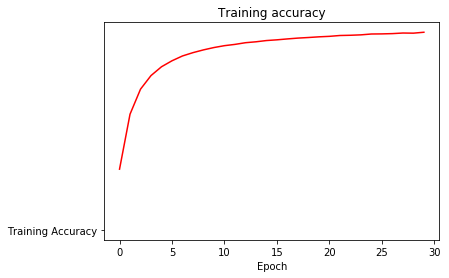

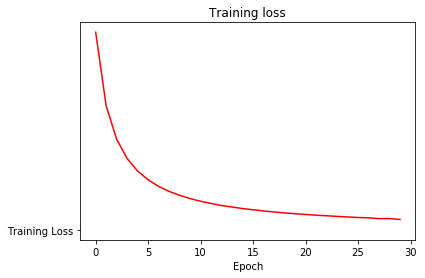

In [25]:
kernel_initializer='glorot_uniform'
optimizer=RMSprop(learning_rate=0.0005)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

На такой сетке попробуем исследовать влияние алгоритма оптимизации. Для Адама понизим ещё параметр обучения, так как он обычно быстро сходится, а для SGD наоборот.

Epoch 1/30
131/131 [==============================] - 23s 177ms/step - loss: 2.4931 - acc: 0.4443
Epoch 2/30
131/131 [==============================] - 23s 176ms/step - loss: 1.1955 - acc: 0.7683
Epoch 3/30
131/131 [==============================] - 23s 175ms/step - loss: 0.7063 - acc: 0.8794
Epoch 4/30
131/131 [==============================] - 23s 176ms/step - loss: 0.4735 - acc: 0.9224
Epoch 5/30
131/131 [==============================] - 23s 175ms/step - loss: 0.3434 - acc: 0.9437
Epoch 6/30
131/131 [==============================] - 23s 178ms/step - loss: 0.2618 - acc: 0.9577
Epoch 7/30
131/131 [==============================] - 23s 175ms/step - loss: 0.2066 - acc: 0.9675
Epoch 8/30
131/131 [==============================] - 23s 175ms/step - loss: 0.1668 - acc: 0.9746
Epoch 9/30
131/131 [==============================] - 23s 175ms/step - loss: 0.1365 - acc: 0.9802
Epoch 10/30
131/131 [==============================] - 23s 175ms/step - loss: 0.1127 - acc: 0.9846
Epoch 11/30
131/131

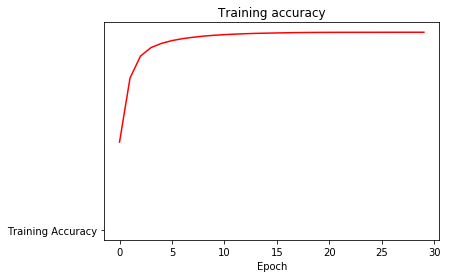

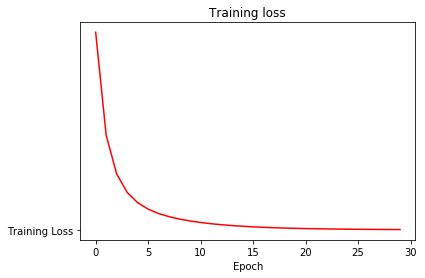

In [26]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0001)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/30
131/131 [==============================] - 23s 177ms/step - loss: 3.4185 - acc: 0.1563
Epoch 2/30
131/131 [==============================] - 23s 179ms/step - loss: 3.0490 - acc: 0.3216
Epoch 3/30
131/131 [==============================] - 23s 176ms/step - loss: 2.7172 - acc: 0.4284
Epoch 4/30
131/131 [==============================] - 23s 176ms/step - loss: 2.4334 - acc: 0.4827
Epoch 5/30
131/131 [==============================] - 23s 175ms/step - loss: 2.1930 - acc: 0.5227
Epoch 6/30
131/131 [==============================] - 23s 175ms/step - loss: 1.9873 - acc: 0.5612
Epoch 7/30
131/131 [==============================] - 23s 175ms/step - loss: 1.8104 - acc: 0.5988
Epoch 8/30
131/131 [==============================] - 23s 175ms/step - loss: 1.6580 - acc: 0.6316
Epoch 9/30
131/131 [==============================] - 23s 175ms/step - loss: 1.5258 - acc: 0.6607
Epoch 10/30
131/131 [==============================] - 23s 175ms/step - loss: 1.4109 - acc: 0.6863
Epoch 11/30
131/131

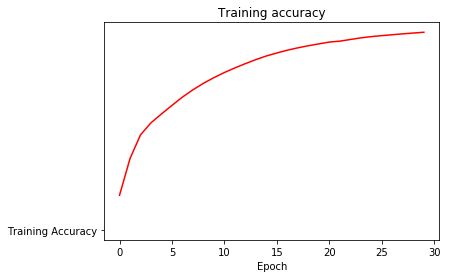

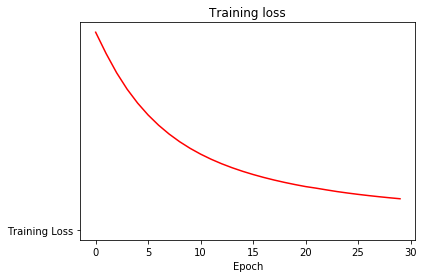

In [27]:
kernel_initializer='glorot_uniform'
optimizer=SGD(learning_rate=0.01)
epochs=30

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='relu', kernel_initializer=kernel_initializer),
    Dense(128, activation='relu', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Адам даёт лучший результат. Продолжим его использовать. Теперь исследуем влияние функции активации.

Epoch 1/20
131/131 [==============================] - 23s 176ms/step - loss: 3.5429 - acc: 0.1045
Epoch 2/20
131/131 [==============================] - 23s 175ms/step - loss: 3.1708 - acc: 0.2617
Epoch 3/20
131/131 [==============================] - 23s 176ms/step - loss: 2.7678 - acc: 0.3871
Epoch 4/20
131/131 [==============================] - 23s 175ms/step - loss: 2.3755 - acc: 0.4725
Epoch 5/20
131/131 [==============================] - 23s 175ms/step - loss: 2.0461 - acc: 0.5359
Epoch 6/20
131/131 [==============================] - 23s 176ms/step - loss: 1.7670 - acc: 0.6018
Epoch 7/20
131/131 [==============================] - 23s 176ms/step - loss: 1.5248 - acc: 0.6637
Epoch 8/20
131/131 [==============================] - 23s 175ms/step - loss: 1.3136 - acc: 0.7184
Epoch 9/20
131/131 [==============================] - 23s 177ms/step - loss: 1.1320 - acc: 0.7700
Epoch 10/20
131/131 [==============================] - 23s 176ms/step - loss: 0.9779 - acc: 0.8135
Epoch 11/20
131/131

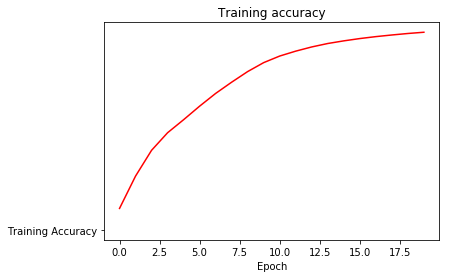

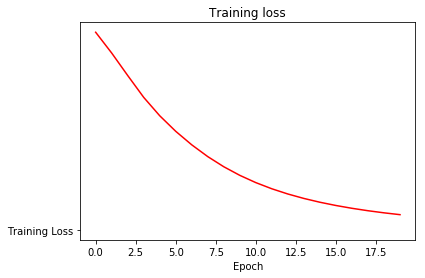

In [28]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='sigmoid', kernel_initializer=kernel_initializer),
    Dense(128, activation='sigmoid', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/20
131/131 [==============================] - 23s 176ms/step - loss: 2.4854 - acc: 0.4123
Epoch 2/20
131/131 [==============================] - 23s 176ms/step - loss: 1.3429 - acc: 0.7262
Epoch 3/20
131/131 [==============================] - 23s 176ms/step - loss: 0.8346 - acc: 0.8567
Epoch 4/20
131/131 [==============================] - 23s 175ms/step - loss: 0.5651 - acc: 0.9129
Epoch 5/20
131/131 [==============================] - 23s 179ms/step - loss: 0.4094 - acc: 0.9404
Epoch 6/20
131/131 [==============================] - 23s 176ms/step - loss: 0.3110 - acc: 0.9561
Epoch 7/20
131/131 [==============================] - 23s 176ms/step - loss: 0.2443 - acc: 0.9665
Epoch 8/20
131/131 [==============================] - 23s 176ms/step - loss: 0.1966 - acc: 0.9740
Epoch 9/20
131/131 [==============================] - 23s 176ms/step - loss: 0.1610 - acc: 0.9795
Epoch 10/20
131/131 [==============================] - 23s 176ms/step - loss: 0.1335 - acc: 0.9839
Epoch 11/20
131/131

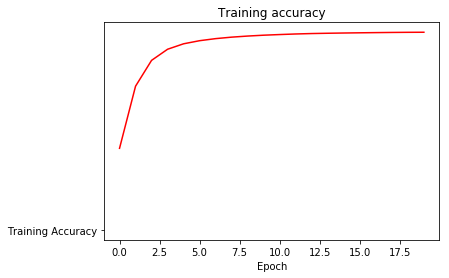

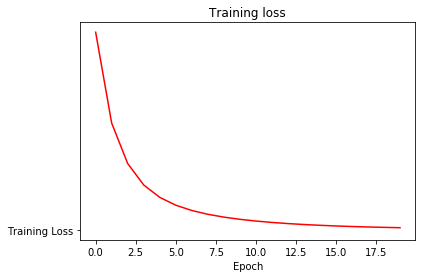

In [29]:
kernel_initializer='glorot_uniform'
optimizer=Adam(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Гиперболический тангенс даёт лучшие результаты. Продолжим его использовать и попробуем другие методы инициализации весов.

Epoch 1/20
131/131 [==============================] - 23s 177ms/step - loss: 2.4125 - acc: 0.4413
Epoch 2/20
131/131 [==============================] - 23s 176ms/step - loss: 1.2619 - acc: 0.7572
Epoch 3/20
131/131 [==============================] - 23s 176ms/step - loss: 0.7795 - acc: 0.8719
Epoch 4/20
131/131 [==============================] - 23s 176ms/step - loss: 0.5285 - acc: 0.9189
Epoch 5/20
131/131 [==============================] - 23s 176ms/step - loss: 0.3834 - acc: 0.9438
Epoch 6/20
131/131 [==============================] - 23s 176ms/step - loss: 0.2915 - acc: 0.9586
Epoch 7/20
131/131 [==============================] - 23s 177ms/step - loss: 0.2289 - acc: 0.9686
Epoch 8/20
131/131 [==============================] - 23s 177ms/step - loss: 0.1840 - acc: 0.9760
Epoch 9/20
131/131 [==============================] - 23s 177ms/step - loss: 0.1504 - acc: 0.9816
Epoch 10/20
131/131 [==============================] - 23s 177ms/step - loss: 0.1244 - acc: 0.9855
Epoch 11/20
131/131

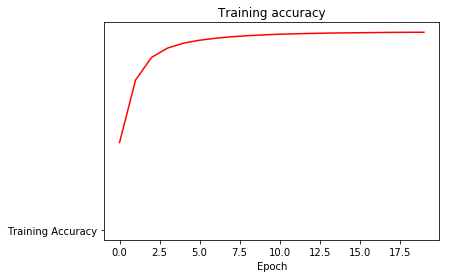

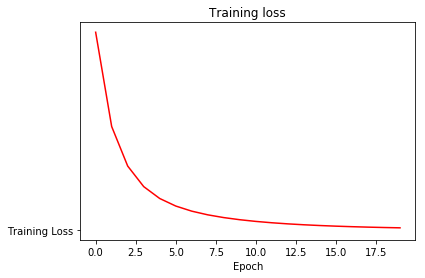

In [30]:
kernel_initializer='glorot_normal'
optimizer=Adam(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/20
131/131 [==============================] - 23s 176ms/step - loss: 2.4512 - acc: 0.4355
Epoch 2/20
131/131 [==============================] - 23s 176ms/step - loss: 1.2750 - acc: 0.7518
Epoch 3/20
131/131 [==============================] - 23s 175ms/step - loss: 0.7972 - acc: 0.8676
Epoch 4/20
131/131 [==============================] - 23s 179ms/step - loss: 0.5470 - acc: 0.9160
Epoch 5/20
131/131 [==============================] - 23s 176ms/step - loss: 0.3994 - acc: 0.9425
Epoch 6/20
131/131 [==============================] - 23s 176ms/step - loss: 0.3049 - acc: 0.9570
Epoch 7/20
131/131 [==============================] - 23s 176ms/step - loss: 0.2403 - acc: 0.9676
Epoch 8/20
131/131 [==============================] - 23s 176ms/step - loss: 0.1939 - acc: 0.9748
Epoch 9/20
131/131 [==============================] - 23s 176ms/step - loss: 0.1592 - acc: 0.9802
Epoch 10/20
131/131 [==============================] - 23s 176ms/step - loss: 0.1322 - acc: 0.9846
Epoch 11/20
131/131

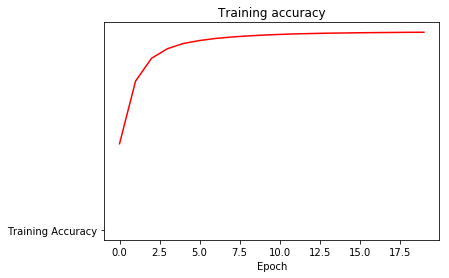

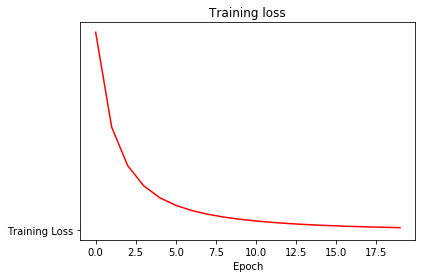

In [31]:
kernel_initializer='he_normal'
optimizer=Adam(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Epoch 1/20
131/131 [==============================] - 23s 177ms/step - loss: 2.3950 - acc: 0.4433
Epoch 2/20
131/131 [==============================] - 23s 176ms/step - loss: 1.2308 - acc: 0.7608
Epoch 3/20
131/131 [==============================] - 23s 176ms/step - loss: 0.7652 - acc: 0.8744
Epoch 4/20
131/131 [==============================] - 23s 176ms/step - loss: 0.5261 - acc: 0.9201
Epoch 5/20
131/131 [==============================] - 23s 175ms/step - loss: 0.3861 - acc: 0.9436
Epoch 6/20
131/131 [==============================] - 23s 176ms/step - loss: 0.2959 - acc: 0.9579
Epoch 7/20
131/131 [==============================] - 23s 175ms/step - loss: 0.2338 - acc: 0.9680
Epoch 8/20
131/131 [==============================] - 23s 175ms/step - loss: 0.1889 - acc: 0.9753
Epoch 9/20
131/131 [==============================] - 23s 176ms/step - loss: 0.1550 - acc: 0.9808
Epoch 10/20
131/131 [==============================] - 23s 179ms/step - loss: 0.1289 - acc: 0.9851
Epoch 11/20
131/131

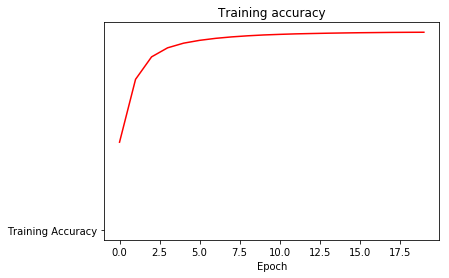

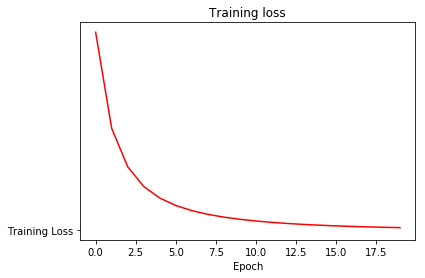

In [32]:
kernel_initializer='he_uniform'
optimizer=Adam(learning_rate=0.0001)
epochs=20

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Нет особой разницы. Ещё попробуем тренировать больше эпох.

Epoch 1/50
131/131 [==============================] - 23s 176ms/step - loss: 2.4455 - acc: 0.4357
Epoch 2/50
131/131 [==============================] - 23s 176ms/step - loss: 1.2811 - acc: 0.7543
Epoch 3/50
131/131 [==============================] - 23s 178ms/step - loss: 0.7935 - acc: 0.8701
Epoch 4/50
131/131 [==============================] - 23s 176ms/step - loss: 0.5411 - acc: 0.9182
Epoch 5/50
131/131 [==============================] - 23s 176ms/step - loss: 0.3944 - acc: 0.9429
Epoch 6/50
131/131 [==============================] - 23s 176ms/step - loss: 0.3013 - acc: 0.9581
Epoch 7/50
131/131 [==============================] - 23s 176ms/step - loss: 0.2377 - acc: 0.9676
Epoch 8/50
131/131 [==============================] - 23s 176ms/step - loss: 0.1917 - acc: 0.9747
Epoch 9/50
131/131 [==============================] - 23s 176ms/step - loss: 0.1573 - acc: 0.9801
Epoch 10/50
131/131 [==============================] - 23s 176ms/step - loss: 0.1306 - acc: 0.9840
Epoch 11/50
131/131

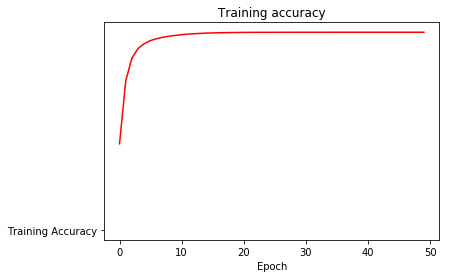

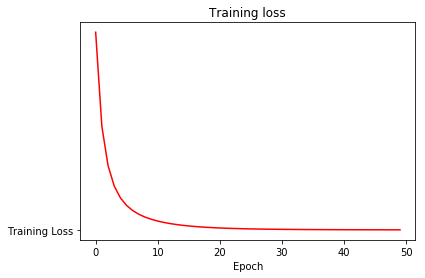

In [33]:
kernel_initializer='he_uniform'
optimizer=Adam(learning_rate=0.0001)
epochs=50

model = tf.keras.models.Sequential([
    Flatten(input_shape=TARGET_SIZE + (3,)),
    Dense(256, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(128, activation='tanh', kernel_initializer=kernel_initializer),
    Dense(43, activation='softmax')
])

train_model(model, kernel_initializer, optimizer, epochs)

Сеть не обобщается хорошо на тестовую выборку. Методы регуляризации могут помочь, но снача надо попробовать свёрточные сети.